In [1]:
import numpy as np, matplotlib.pyplot as plt
from math import pi

Параметры заданные преподавателем:

$$ c = 1,65 $$
$$ k = 0,59 $$
$$ R = 5 $$
$$ u_c = 0 $$
$$ l = 0,5 $$
$$ \alpha = 0,003 $$
$$ T = 40 $$
$$ \psi(\theta) = u_c + cos^4 (\theta) $$

In [4]:
c = 1.65
k = 0.59
R = 5
uc = 0
l = 0.5
alpha = 0.003
T = 40

def psi(theta):
    return uc + np.cos(theta) ** 4

I = 128
K = 128
t = np.linspace(0, T, K + 1)
tht = np.linspace(0.001, pi-0.001, I + 1)

Начальное распределение температуры:

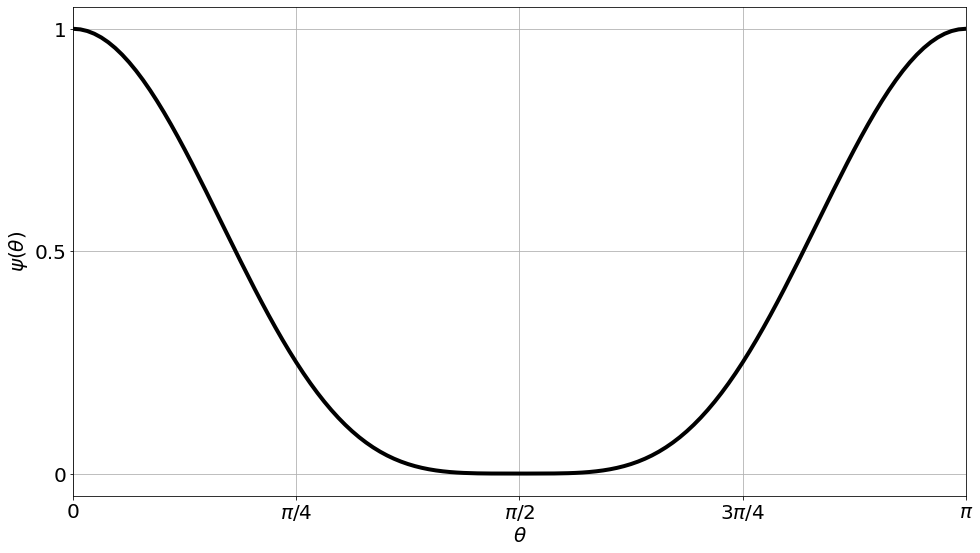

In [5]:
f = plt.figure(figsize=[16, 9])
plt.plot(tht, psi(tht), lw=4, c='black')
plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.grid()
plt.show()

In [6]:
ht = t[2] - t[1]
htht = tht[2] - tht[1]

In [7]:
A = k / (c * R ** 2)
B = alpha / (c * l)

beta_c = B * ht + 2 * A * ht / (htht ** 2) + 1
gam = -A * ht / (htht ** 2) * (1 + htht / (2 * np.tan(tht[:-1])))
eps = -A * ht / (htht ** 2) * (1 - htht / (2 * np.tan(tht[1:])))
eta = B * ht * uc

mu = B * ht + 4 * A * ht / (htht ** 2) + 1
sigma = - 2 * A * ht / (htht ** 2) 

In [8]:
v = np.zeros([K + 1, I + 1])
v[0, :] = psi(tht)

In [9]:
# def TDMASolve(a, b, c, d):
#     n = len(a)
#     ac, bc, cc, dc = map(np.array, (a, b, c, d))
#     xc = []
#     for j in range(1, n):
#         if(bc[j - 1] == 0):
#             ier = 1
#             return
#         ac[j] = ac[j]/bc[j-1]
#         bc[j] = bc[j] - ac[j]*cc[j-1]
#     if(b[n-1] == 0):
#         ier = 1
#         return
#     for j in range(1, n):
#         dc[j] = dc[j] - ac[j]*dc[j-1]
#     dc[n-1] = dc[n-1]/bc[n-1]
#     for j in range(n-2, -1, -1):
#         dc[j] = (dc[j] - cc[j]*dc[j+1])/bc[j]
#     return dc

In [10]:
# beta = beta_c * np.ones(I + 1)
# eps[-1] = sigma
# gam[0] = sigma

# for k_ind in range(1,K+1):
#     v[k_ind, :] = TDMASolve(eps, beta, gam, v[k_ind - 1, :])

In [11]:
import time

In [12]:
beta = beta_c * np.ones(I + 1)
eps[-1] = sigma
gam[0] = sigma

matrix = np.diag(beta) + np.diag(eps, -1) + np.diag(gam, 1)

t_from = time.time()

for k_ind in range(1,K+1):
    v[k_ind, :] = np.linalg.inv(matrix) @ v[k_ind - 1, :]

t_matrix = time.time() - t_from
print('Время для матричного метода: ', str(t_matrix), ' сек')

Время для матричного метода:  0.3661224842071533  сек


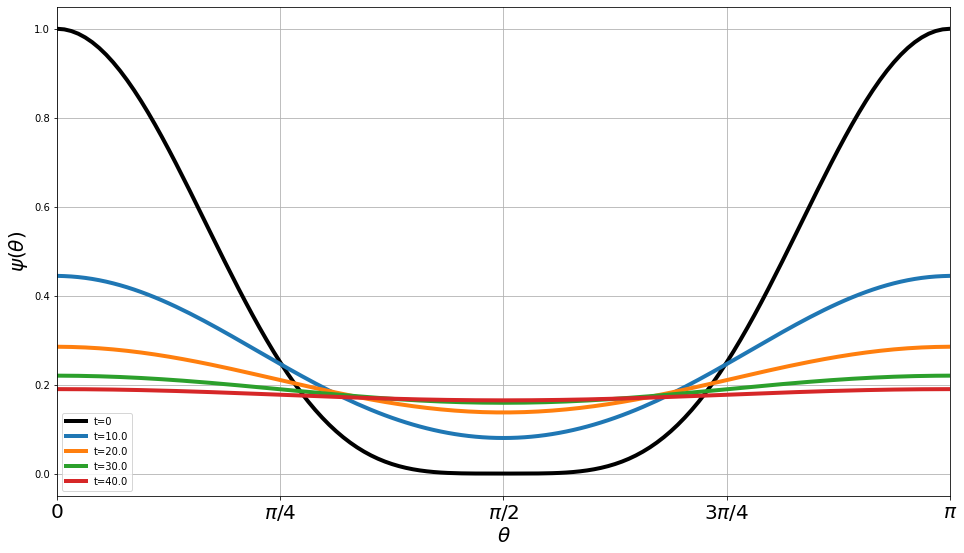

In [13]:
f = plt.figure(figsize=[16, 9])
plt.plot(tht, v[0, :], lw=4, c='black', label='t=0')
for ind in [int(K / 4), int(K / 2), int(3 * K / 4), K]:
    plt.plot(tht, v[ind, :], lw=4, label='t='+str(t[ind]))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.show()

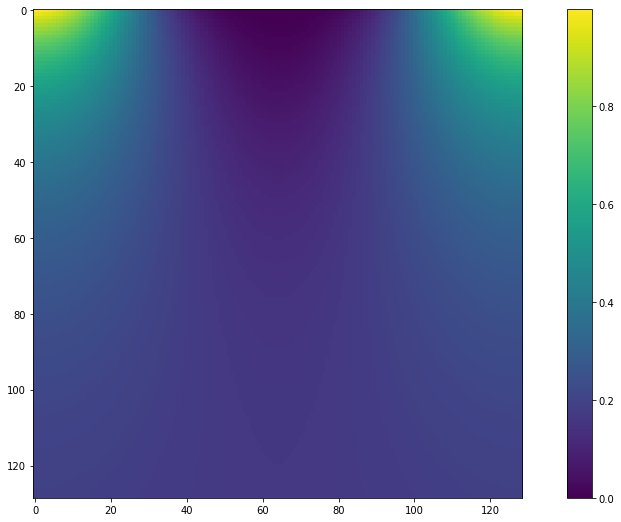

In [14]:
f = plt.figure(figsize=[16, 9])
plt.imshow(v)
plt.colorbar()
plt.show()

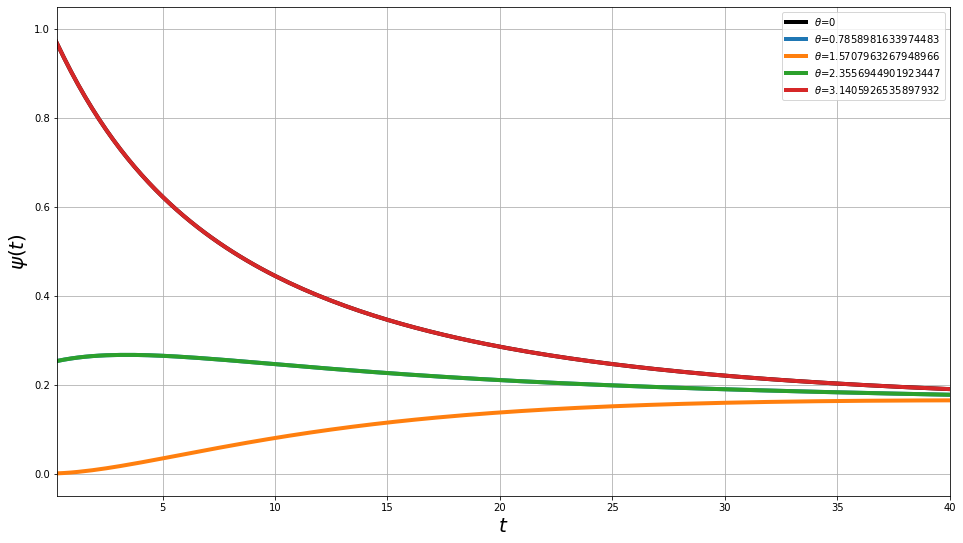

In [15]:
f = plt.figure(figsize=[16, 9])
plt.plot(t, v[:, 0], lw=4, c='black', label='$\\theta$=0')
for ind in [int(I / 4), int(I / 2), int(3 * I / 4), I]:
    plt.plot(t, v[:, ind], lw=4, label='$\\theta$='+str(tht[ind]))
plt.xlim([t[1], t[-1]])
plt.xlabel('$t$', fontsize=20)
plt.ylabel('${\\psi(t)}$', fontsize=20)
plt.legend()
plt.grid()
plt.show()

Простейшая неявная схема

**Реализация алгоритма прогонки**

$$ \begin{pmatrix}
c_1 & b_1 & 0 & ... & 0\\
a_2 & c_2 & b_2 & ... & 0 \\
\vdots &  & \ddots &  & \vdots \\
0 & ... & a_{n-1} & c_{n-1} & b_{n-1} \\
0 & ... & 0 & a_n & c_n \\
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
\vdots\\
x_{n-1}\\
x_n\\
\end{pmatrix}
=
\begin{pmatrix}
f_1\\
f_2\\
\vdots\\
f_{n-1}\\
f_n\\
\end{pmatrix}
$$

Прямой ход:
$$
\xi_n = - a_n / c_n, 
$$
$$
\xi_i = - \frac{a_i}{c_i + b_i \xi_{i+1}}, i = n-1,...,2
$$
$$
\eta_n = f_n / c_n, 
$$
$$
\eta_i = \frac{f_i - b_i \eta_{i+1}}{c_i + b_i \xi_{i+1}}, i = n-1,...,2
$$
Обратный ход:
$$
x_1 = \frac{f_1 - b_1 \eta_2}{b_1 \xi_2 + c_1}
$$
$$
x_{i+1} = \xi_{i+1} x_i + \eta_{i+1}, i = 1,...,n-1
$$


In [16]:
def tri_diag_solver_left(a, c, b, f):
    n = c.size
    k = n - 1
    xsi = np.zeros(k)
    eta = np.zeros(k)
    x = np.zeros(n)
    
    xsi[-1] = - a[-1] / c[-1]
    eta[-1] = f[-1] / c[-1]
    
    for ind in range(k-2, -1, -1):
        xsi[ind] = - a[ind] / (c[ind + 1] + b[ind + 1] * xsi[ind + 1])
        eta[ind] = (f[ind + 1] - b[ind + 1] * eta[ind + 1]) / (c[ind + 1] + b[ind + 1] * xsi[ind + 1])
    x[0] = (f[0] - b[0] * eta[0]) / (b[0] * eta[0] + c[0])
    
    for ind in range(1, n):
        x[ind] = xsi[ind - 1] * x[ind - 1] + eta[ind - 1]
    return x

In [17]:
def tri_diag_solver_right(a, c, b, f):
    n = c.size
    k = n - 1
    alpha = np.zeros(k)
    beta = np.zeros(k)
    x = np.zeros(n)
    
    alpha[0] = - b[0] / c[0]
    beta[0] = f[0] / c[0]
    
    for ind in range(1, k):
        alpha[ind] = - b[ind] / (a[ind - 1] * alpha[ind - 1] + c[ind])
        beta[ind] = (f[ind] - a[ind - 1] * beta[ind - 1]) / (a[ind - 1] * alpha[ind - 1] + c[ind])
        
    x[-1] = (f[-1] - a[-1] * beta[-1]) / (a[-1] * alpha[-1] + c[-1])
    
    for ind in range(n - 2, -1, -1):
        x[ind] = alpha[ind] * x[ind + 1] + beta[ind]
    return x

In [18]:
v_prog = np.zeros([K + 1, I + 1])
v_prog[0, :] = psi(tht)

t_from = time.time()
for k_ind in range(1,K+1):
    v_prog[k_ind, :] = tri_diag_solver_right(eps, beta, gam, v_prog[k_ind - 1, :])
    
t_tridiag = time.time() - t_from
print('Время для матричного метода: ' + str(t_tridiag) + ' ceк')

Время для матричного метода: 0.028424501419067383 ceк


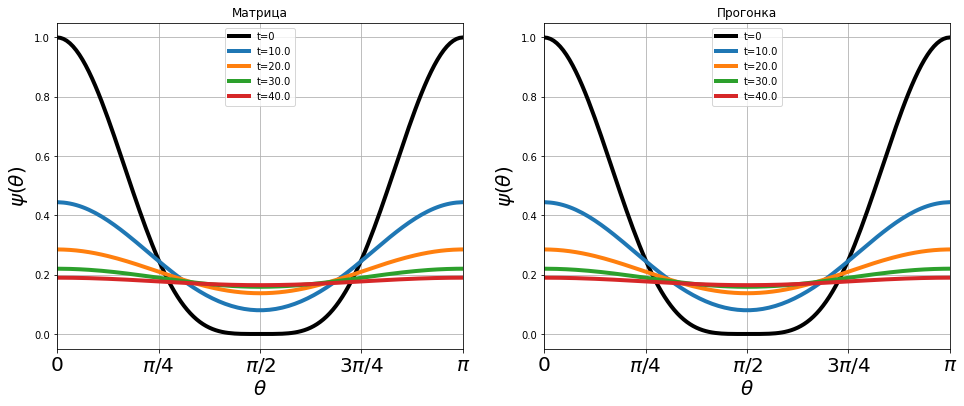

In [19]:
f = plt.figure(figsize=[16, 6])

plt.subplot(1, 2, 1)
plt.plot(tht, v[0, :], lw=4, c='black', label='t=0')
for ind in [int(K / 4), int(K / 2), int(3 * K / 4), K]:
    plt.plot(tht, v[ind, :], lw=4, label='t='+str(t[ind]))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.title('Матрица')

plt.subplot(1, 2, 2)
plt.plot(tht, v_prog[0, :], lw=4, c='black', label='t=0')
for ind in [int(K / 4), int(K / 2), int(3 * K / 4), K]:
    plt.plot(tht, v_prog[ind, :], lw=4, label='t='+str(t[ind]))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.title('Прогонка')
plt.show()

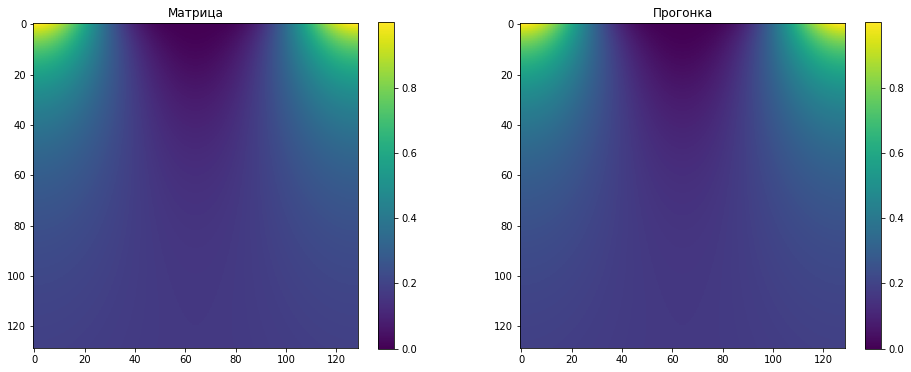

In [20]:
f = plt.figure(figsize=[16, 6])
plt.subplot(1, 2, 1)
plt.imshow(v)
plt.colorbar()
plt.title('Матрица')
plt.subplot(1, 2, 2)
plt.imshow(v_prog)
plt.colorbar()
plt.title('Прогонка')
plt.show()

Отклонение решения м. прогонки и матричным методом

In [21]:
print(sum(sum(np.abs(v_prog - v) ** 2)))

1.929241819072655e-26


In [22]:
print('м. прогонки быстрее матричного м. в ' + str(round(t_matrix / t_tridiag)) + ' раз(-а)')

м. прогонки быстрее матричного м. в 13 раз(-а)


Anton

In [ ]:
v_ex = np.zeros([K + 1, I + 1])
v_ex[0, :] = psi(tht)

In [ ]:
c = 1.65
k = 0.59
R = 5
uc = 0
l = 0.5
alpha = 0.003
T = 40

def psi(theta):
    return uc + np.cos(theta) ** 4

I = 128
K = 128
t = np.linspace(0, T, I + 1)
tht = np.linspace(0.1, pi-0.1, K + 1)

In [ ]:
triangle = k * ht / (R ** 2) / c / (htht ** 2)
circle = alpha * ht / l / c
square = k * ht / (R ** 2) / np.tan(tht) / 2 / htht / c

In [ ]:
for k_ind in range(1, K + 1):
    v_ex[k_ind, 0] = (1 - circle - 2 * triangle) * v_ex[k_ind - 1, 0] + 2 * triangle * (v_ex[k_ind - 1, 1])
    for i_ind in range(1, I):
        v_ex[k_ind, i_ind] = (1 - 2 * triangle - circle) * v_ex[k_ind - 1, i_ind] + (square[i_ind] + triangle) * v_ex[k_ind - 1, i_ind + 1] + (triangle - square[i_ind]) * v_ex[k_ind - 1, i_ind - 1]
    v_ex[k_ind, I] = (1 - circle - 2 * triangle) * v_ex[k_ind - 1, I] + 2 * triangle * (v_ex[k_ind - 1, I - 1])

In [ ]:
f = plt.figure(figsize=[16, 9])
plt.plot(tht, v_ex[0, :], lw=4, c='black', label='t=0')
for ind in [int(K / 4), int(K / 2), int(K / 4 * 3), int(K)]:
    plt.plot(tht, v_ex[ind, :], lw=4, label='t='+str(t[ind]))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${v(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.show()

In [ ]:
f = plt.figure(figsize=[16, 9])
plt.plot(t, v_ex[:, 0], lw=4, c='black', label='$\\theta$=0')
# for ind in [int(K / 4), int(K / 2), int(3 * K / 4), K]:
#     plt.plot(t, v_ex[:, ind], lw=4, label='$\\theta$='+str(tht[ind]))
plt.xlim([t[1], t[-1]])
plt.xlabel('$t$', fontsize=20)
plt.ylabel('${\\psi(t)}$', fontsize=20)
plt.legend()
plt.grid()
plt.show()